In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib import gridspec

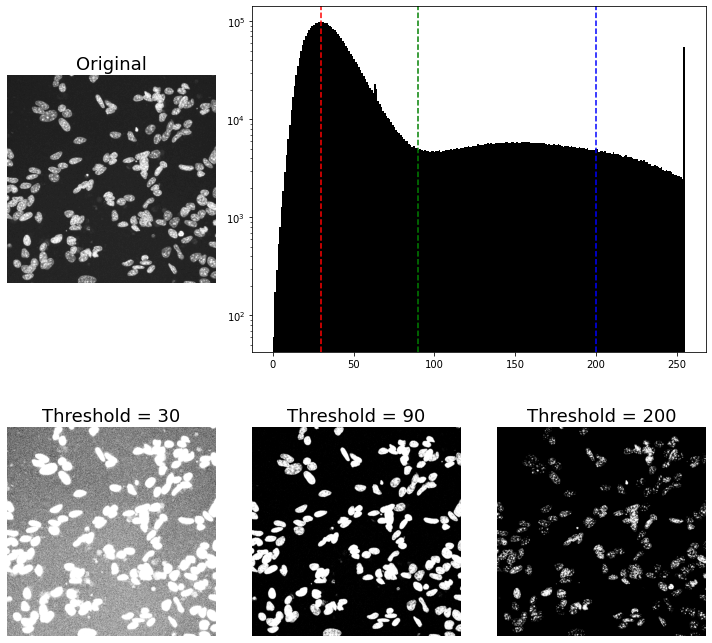

In [4]:
img = imread("nuclei_DAPI.tif")

fig = plt.figure(constrained_layout=False, figsize=(10, 10))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

ax1.imshow(img, cmap="gray")
ax1.axis("off")
ax1.set_title("Original", fontsize=18)
ax2.hist(img.ravel(), bins=256, log=True, color="black")
ax2.axvline(30, color="red", linestyle="--")
ax2.axvline(90, color="green", linestyle="--")
ax2.axvline(200, color="blue", linestyle="--")
ax3.imshow(img > 30, cmap="gray")
ax3.axis("off")
ax3.set_title("Threshold = 30", fontsize=18)
ax4.imshow(img > 90, cmap="gray")
ax4.axis("off")
ax4.set_title("Threshold = 90", fontsize=18)
ax5.imshow(img > 200, cmap="gray")
ax5.axis("off")
ax5.set_title("Threshold = 200", fontsize=18)
plt.tight_layout()

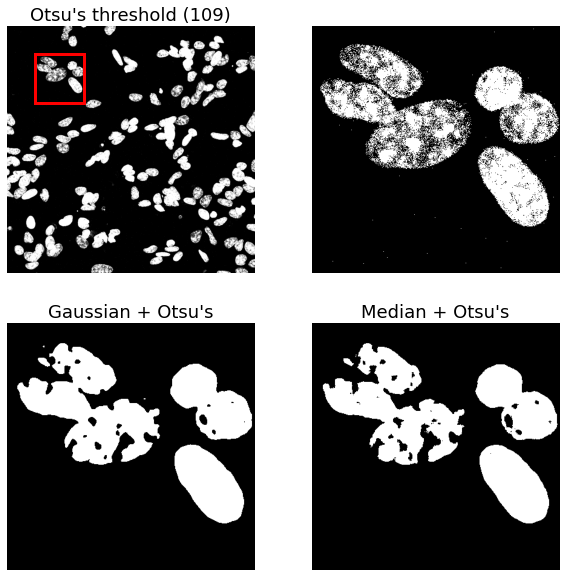

In [5]:
from skimage.filters import threshold_otsu, gaussian, median
from skimage import img_as_ubyte
from matplotlib.patches import Rectangle
import numpy as np

t = threshold_otsu(img)

img_gauss = gaussian(img, 3)
img_median = median(img, selem=np.ones((10, 10)))

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0,0].imshow(img > t, cmap="gray")
# Draw a rectangle at (200;200) with side 500 pixels
r = Rectangle((230, 230), 410, 410, color="red", linewidth=3, fill=None)
ax[0,0].add_patch(r)

ax[0,1].imshow(img[230:640, 230:640] > t, cmap="gray")

ax[1,0].imshow(img_as_ubyte(img_gauss[230:640, 230:640]) > t, cmap="gray")
ax[1,1].imshow(img_as_ubyte(img_median[230:640, 230:640]) > t, cmap="gray")

for a in ax.ravel():
    a.axis("off")

ax[0,0].set_title(f"Otsu's threshold ({t})", fontsize=18)
ax[1,0].set_title(f"Gaussian + Otsu's", fontsize=18)
ax[1,1].set_title(f"Median + Otsu's", fontsize=18)

plt.show()

Text(0.5, 1.0, 'Closing + dilation')

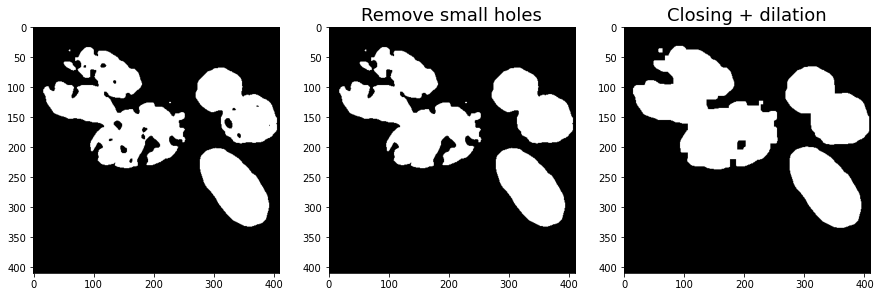

In [6]:
from skimage.morphology import remove_small_holes, dilation, closing
from skimage import img_as_ubyte

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
img_thresh = img_as_ubyte(img_gauss[230:640, 230:640]) > t
img_filled = remove_small_holes(img_thresh, 
    area_threshold=200)

img_filled_2 = closing(dilation(img_thresh, selem=np.ones((5, 5))), 
    selem=np.ones((10, 10)))

ax[0].imshow(img_thresh, cmap="gray")
ax[1].imshow(img_filled, cmap="gray")
ax[1].set_title("Remove small holes", fontsize=18)
ax[2].imshow(img_filled_2, cmap="gray")
ax[2].set_title("Closing + dilation", fontsize=18)

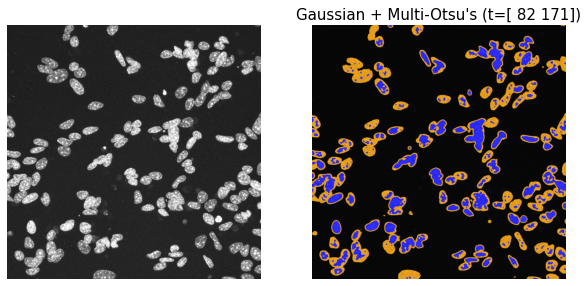

In [7]:
from skimage.filters import threshold_multiotsu, gaussian
from skimage import img_as_ubyte
import numpy as np
from skimage.color import label2rgb

t = threshold_multiotsu(img, classes=3)

img_gaus = img_as_ubyte(gaussian(img, 5))
img_thr = np.digitize(img, t)
img_thr_gaus = np.digitize(img_gaus, t)

img_with_overlay_gaus = label2rgb(img_thr_gaus, image = img, bg_label=0, colors = ["orange", "blue"], alpha = .8)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(img_with_overlay_gaus)
for a in ax:
    a.axis("off")
ax[1].set_title(f"Gaussian + Multi-Otsu's (t={t})", fontsize=15)
plt.show()

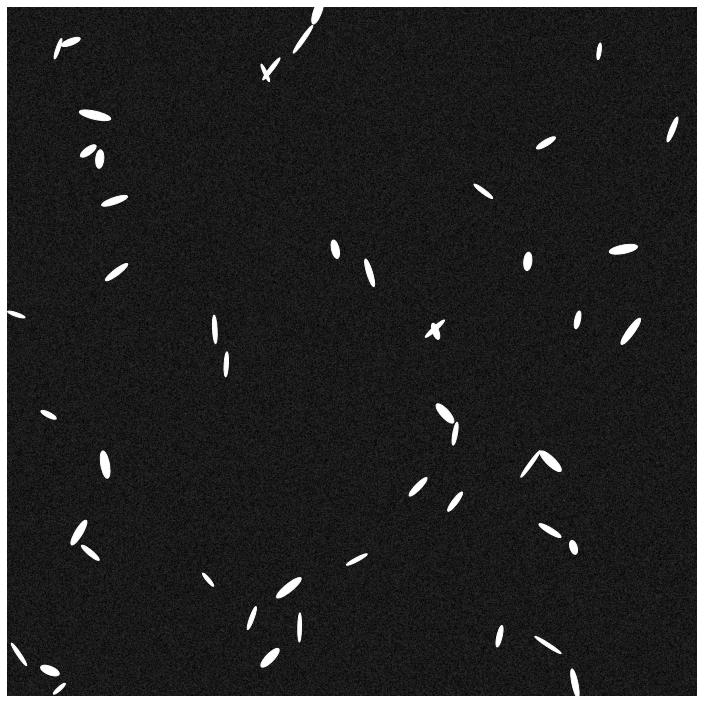

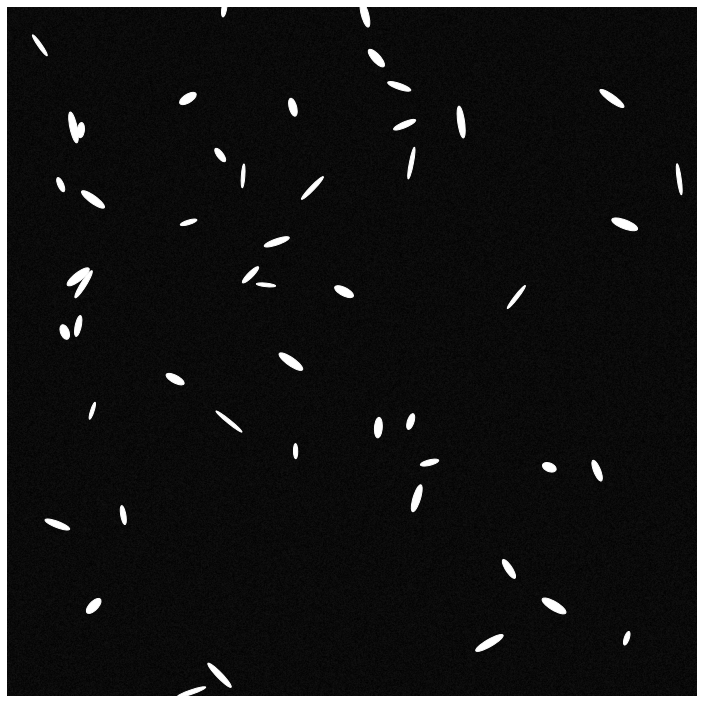

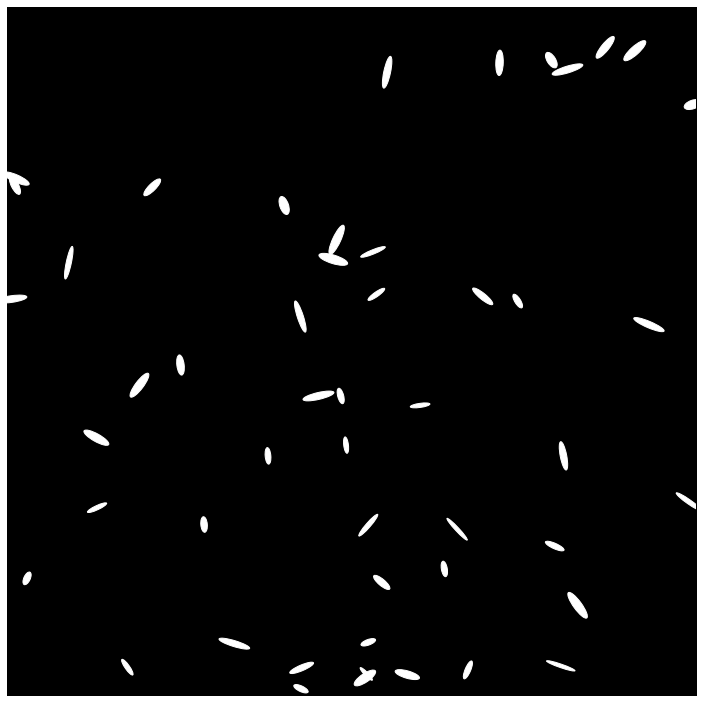

In [8]:
from matplotlib.patches import Ellipse
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from skimage.io import imsave

def gen_ellipses(num_ellipses, base_noise=50):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.axis("off")
    ax.imshow(np.random.random((1024, 1024)) * base_noise, cmap="gray", vmin=0, vmax=255)
    # Pick random centers and draw randomly rotated ellipses
    x, y = np.random.randint(0, 1024, (2, num_ellipses))
    for x_c, y_c in zip(x, y):
        r1 = np.random.random(1) * 30 + 20
        r2 = np.random.random(1) * 8 + 5
        angle = np.random.randint(0, 360)
        ax.add_patch(Ellipse((x_c, y_c), r1, r2, angle=angle, color="white", fill="white"))

    canvas = FigureCanvas(fig)
    canvas.draw()       # draw the canvas, cache the renderer
    img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = img[:,:,0]

    return img

red = gen_ellipses(50, 50)
green = gen_ellipses(50, 20)
yellow = gen_ellipses(50, 0)

imsave("red.png", red)
imsave("green.png", green)
imsave("yellow.png", yellow)

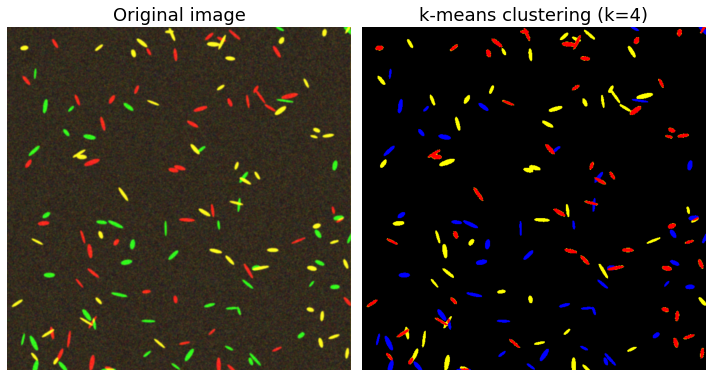

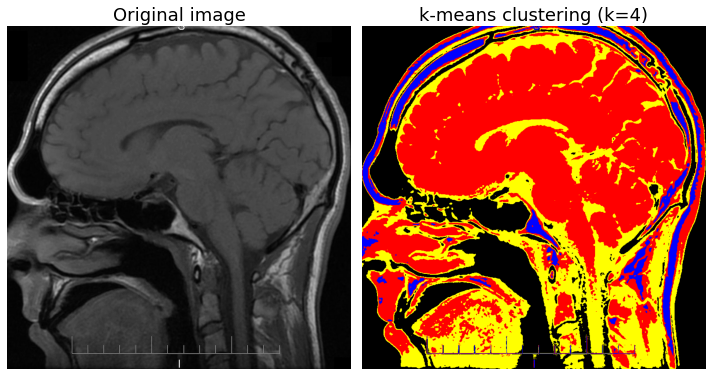

In [13]:
from sklearn.cluster import KMeans
from skimage.color import label2rgb

def segment_k_means(img, k):
    # K-means clustering of blobs
    kmeans = KMeans(n_clusters=4, random_state=42)
    if len(img.shape) == 3:
        kmeans.fit(img.reshape(-1, 3))
        clusters = kmeans.predict(img.reshape(-1, 3)).reshape(img.shape[0], img.shape[1])
    else:
        kmeans.fit(img.reshape(-1, 1))
        clusters = kmeans.predict(img.reshape(-1, 1)).reshape(img.shape)
    return clusters

blobs = imread("blobs_green_red.tif")
blobs_clusters = segment_k_means(blobs, 4)
MRI = imread("MRI_grayscale.png")
MRI_clusters = segment_k_means(MRI, 4)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(blobs)
ax[0].axis("off")
ax[0].set_title("Original image", fontsize=18)
ax[1].imshow(label2rgb(blobs_clusters, bg_label=0))
ax[1].axis("off")
ax[1].set_title("k-means clustering (k=4)", fontsize=18)
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(MRI, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original image", fontsize=18)
ax[1].imshow(label2rgb(MRI_clusters, bg_label=MRI_clusters[0,0]))
ax[1].axis("off")
ax[1].set_title("k-means clustering (k=4)", fontsize=18)
plt.tight_layout()

In [25]:
from fcmeans import FCM
from skimage.exposure import equalize_adapthist

def segment_fuzzy_c_means(img, n_clusters, max_iter):
    fcm = FCM(n_clusters=n_clusters, max_iter=max_iter, eps=1e-5)
    if len(img.shape) == 3:
        fcm.fit(img.reshape(-1, 3))
        clusters = fcm.predict(img.reshape(-1, 3)).reshape(img.shape[0], img.shape[1])
    else:
        fcm.fit(img.reshape(-1, 1))
        clusters = fcm.predict(img.reshape(-1, 1)).reshape(img.shape)

    return clusters

img = imread("chest_xray.jpg")
img_eq = equalize_adapthist(img, clip_limit=0.01)

In [23]:
clusters = segment_fuzzy_c_means(img_eq, max_iter = 10, n_clusters=4)

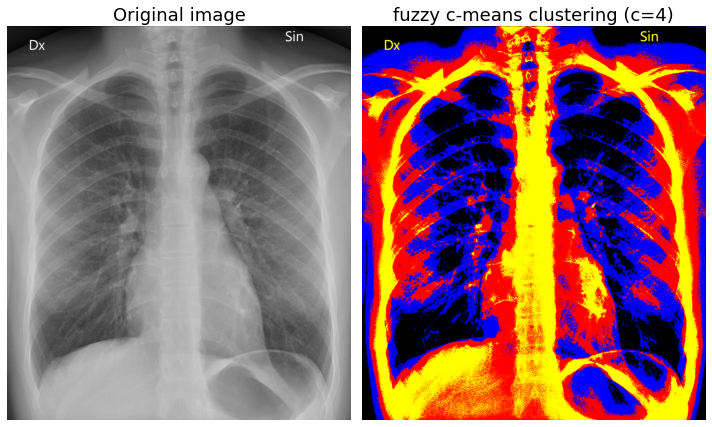

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original image", fontsize=18)
ax[1].imshow(label2rgb(clusters, bg_label=clusters[0, 0]))
ax[1].axis("off")
ax[1].set_title("fuzzy c-means clustering (c=4)", fontsize=18)
plt.tight_layout()

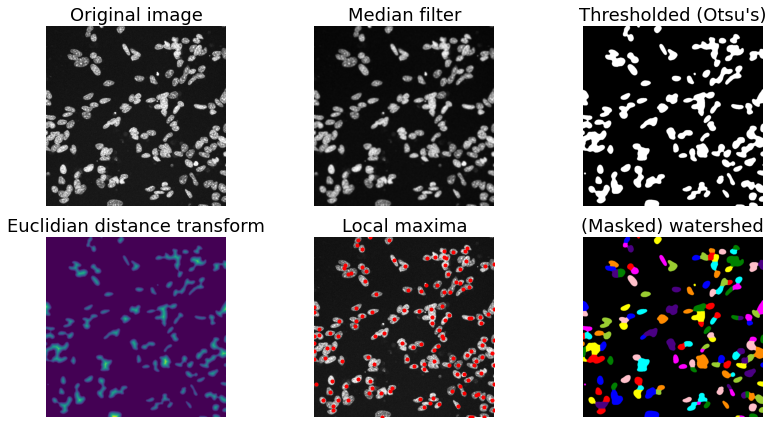

In [58]:
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.filters import median, threshold_otsu
from skimage.morphology import disk
from skimage.transform import rescale
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from scipy.ndimage import distance_transform_edt

img = imread("nuclei_DAPI.tif")
img = rescale(img, 0.5)
img_smooth = median(img, selem=disk(10))
img_otsu = img_smooth > threshold_otsu(img_smooth)
img_edt = distance_transform_edt(img_otsu)
peak_idx = peak_local_max(img_edt, min_distance=10, threshold_abs=0, threshold_rel=0.1, exclude_border=False)
peak_mask = np.zeros_like(img, dtype=bool)
peak_mask[tuple(peak_idx.T)] = True

markers = label(peak_mask)
img_watershed = watershed(-img_edt, markers=markers, mask = img_otsu)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
titles = ["Original image", "Median filter", "Thresholded (Otsu's)", "Euclidian distance transform", "Local maxima", "(Masked) watershed"]

ax[0, 0].imshow(img, cmap="gray")
ax[0, 1].imshow(img_gaus, cmap="gray")
ax[0, 2].imshow(img_otsu, cmap="gray")
ax[1, 0].imshow(img_edt, cmap="viridis")

ax[1, 1].imshow(img, cmap="gray")
ax[1, 1].plot(peak_idx[:, 1], peak_idx[:, 0], "r.")
#ax[1, 1].imshow(peak_mask, cmap="gray", vmax=1)
ax[1, 2].imshow(label2rgb(img_watershed, bg_label=img_watershed[0,0]), cmap="gray")

for i, a in enumerate(ax.ravel()):
    a.axis("off")
    a.set_title(titles[i], fontsize=18)

plt.tight_layout()

In [85]:
from skimage.io import imsave

watershed_img = imread("watershed process.jpg")
print(watershed_img.shape)
plt.imsave(arr=watershed_img[0:210, 30:240], fname="watershed_process_step1.png")
plt.imsave(arr=watershed_img[0:210, 300:510], fname="watershed_process_step2.png")
plt.imsave(arr=watershed_img[0:210, 570:780], fname="watershed_process_step3.png")
plt.imsave(arr=watershed_img[210:420, 30:240], fname="watershed_process_step4.png")
plt.imsave(arr=watershed_img[210:420, 300:510], fname="watershed_process_step5.png")
plt.imsave(arr=watershed_img[210:420, 570:780], fname="watershed_process_step6.png")

(424, 773, 3)


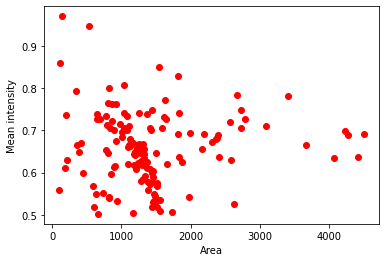

In [100]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd

props = regionprops(img_watershed, intensity_image=img)

areas = [prop.area for prop in props]
intens = [prop.mean_intensity for prop in props]

plt.scatter(x=areas, y=intens, color="red")
plt.xlabel("Area")
plt.ylabel("Mean intensity")
plt.plot()

# Alternatively, with regionprops_table
tbl = regionprops_table(img_watershed, intensity_image=img, 
                properties=["area", "mean_intensity"])      
tbl = pd.DataFrame(tbl)
tbl.to_csv("cells_area_intensity.csv", index=False)